In [0]:
import torch
from torchvision import transforms, models
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

cuda
Tesla P100-PCIE-16GB


In [0]:
style_weight = 0.2
alpha = 1
beta = 1e6
representation_layers = {
    '0': 'conv1_1',
    '5': 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '28': 'conv5_1'
}

In [0]:
def get_model():
  vgg = models.vgg19(pretrained=True).features
  for param in vgg.parameters():
    param.requires_grad_(False)

  
  return vgg.to(device)

In [0]:
def get_features(image, model):
  features = {}
  for index, layer in model._modules.items():
    image = layer(image)
    if index in representation_layers:
      features[representation_layers[index]] = image

  return features

In [0]:
def gram_matrix(tensor):
  _, depth, height, width = tensor.size()
  tensor = tensor.view(depth, height*width)
  gram_matrix = torch.matmul(tensor, tensor.t())
  return gram_matrix

In [0]:
def get_content_loss(output_features, content_features):
  content_loss = torch.mean((output_features - content_features)**2)
  return content_loss

In [0]:
def get_style_loss(style_weight, output_gram, style_gram):
  style_loss = style_weight*torch.mean((output_gram - style_gram)**2)
  return style_loss

In [0]:
def get_total_loss(content_weight, style_weight, content_loss, style_loss):
  total_loss = content_weight*content_loss + style_weight*style_loss
  return total_loss

In [0]:
def load_image(path, max_size = 512):
  img = Image.open(path).convert('RGB')
  print(img.size)
  #convert to lambda
  if max(img.size) > max_size:
    size = max_size  
  else: 
    size = max(img.size)
  print(size)
  transform = transforms.Compose([
                                  transforms.Resize(size),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])

  img = transform(img)[:3,:,:].unsqueeze(0)
  print(img.size())
  return img

In [0]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    return image

(500, 333)
500
torch.Size([1, 3, 500, 750])
(501, 741)
512
torch.Size([1, 3, 757, 512])
Total loss:  690459.3125


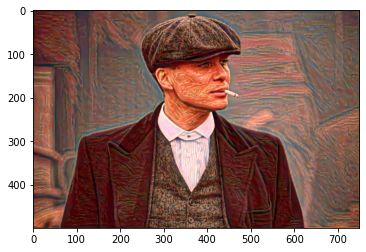

Total loss:  239578.578125


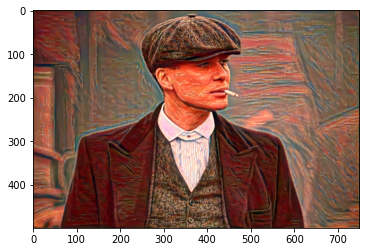

Total loss:  143349.84375


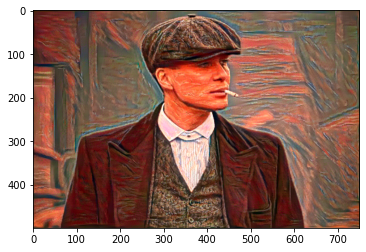

Total loss:  95566.875


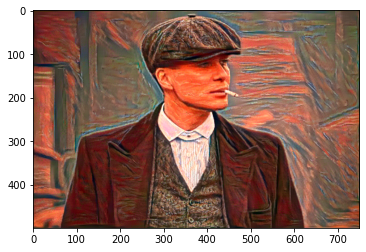

Total loss:  69758.0859375


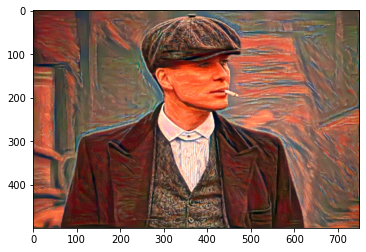

In [28]:
model = get_model()

content = load_image('/content/sample_data/images/content2.jpg').to(device)
style = load_image('/content/sample_data/images/style3.jpg').to(device)
content_features = get_features(content, model)
style_features = get_features(style, model)

#update*
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}
#*update

show_every = 400

target = content.clone().requires_grad_(True).to(device)
optimizer = optim.Adam([target], lr=0.003)
steps = 2000 

for ii in range(1, steps+1):
    
    # get the features from your target image
    output_features = get_features(target, model)
    
    # the content loss
    content_loss = get_content_loss(output_features['conv4_2'], content_features['conv4_2'])
    
    style_loss = 0
    #update
    for layer in style_weights:
        output_feature = output_features[layer]
        output_gram = gram_matrix(output_feature)
        _, d, h, w = output_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((output_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = get_total_loss(alpha, beta, content_loss, style_loss) 

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

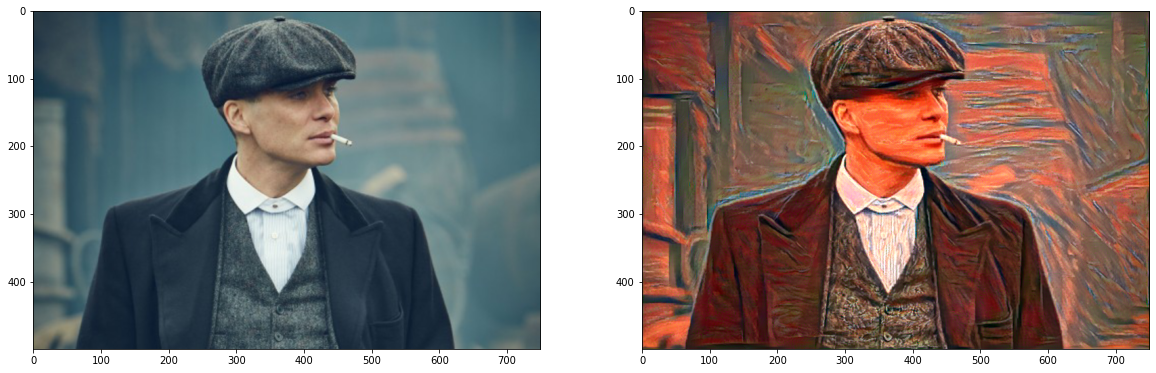

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))